#Anomaly Detection with Variational Autoencoders (VAE)

**Introduction**

This notebook demonstrates how to build and train a Variational Autoencoder (VAE) for anomaly detection using TensorFlow and the MNIST dataset. VAEs are powerful generative models that learn the underlying distribution of normal data and can be leveraged to identify anomalies by measuring reconstruction error.
In this tutorial, we will:

- Load and preprocess the MNIST handwritten digit dataset
- Design and implement a VAE architecture with convolutional layers
- Train the VAE to learn the distribution of normal digit images
- Demonstrate anomaly detection by comparing reconstruction errors between normal digits and random noise

The key insight behind using VAEs for anomaly detection is that they excel at reconstructing data similar to what they were trained on, but struggle with data that differs significantly from their training distribution.

By measuring reconstruction error, we can effectively identify anomalous samples that deviate from the expected patterns.

This approach has applications in fraud detection, manufacturing quality control, network security, and medical diagnostics where identifying unusual patterns can be critical.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

In [30]:
# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [31]:
# Network parameters
original_dim = 28 * 28      # MNIST images are 28x28
input_shape = (28, 28, 1)
intermediate_dim = 256
latent_dim = 2              # Small latent space for visualization
epochs = 50
batch_size = 128

In [32]:
# Sampling function (reparameterization trick)
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [33]:
# -------------------------
# Build the Encoder
# -------------------------
inputs = Input(shape=input_shape, name='encoder_input')
x = Flatten()(inputs)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 784)            │              0 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 256)            │        200,960 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            514 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            514 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 201,988 (789.02 KB)

 Trainable params: 201,988 (789.02 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# -------------------------
# Build the Decoder
# -------------------------
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dense(original_dim, activation='sigmoid')(x)
outputs = Reshape(input_shape)(x)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 784)                 │         201,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,256 (790.06 KB)

 Trainable params: 202,256 (790.06 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# -------------------------
# Custom VAE Model with Custom Training Step
# -------------------------
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        # Unpack the data. If data is a tuple, use the first element.
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Compute the reconstruction loss.
            # tf.keras.losses.binary_crossentropy returns a tensor with shape (batch, 28, 28)
            reconstruction_loss = tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstruction), axis=[1, 2]
            )
            # Compute the KL divergence loss.
            kl_loss = -0.5 * tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            )
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": total_loss}

# Create and compile the VAE
vae = VAE(encoder, decoder)

# Define the custom loss function
def vae_loss(inputs, outputs):
    z_mean, z_log_var, z = encoder(inputs)
    reconstruction = decoder(z)
    reconstruction_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(inputs, reconstruction), axis=[1, 2])
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    return tf.reduce_mean(reconstruction_loss + kl_loss)


# Compile the VAE with the custom loss
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss=vae_loss)

# Build the model by providing an input shape (required to show the summary)
vae.build(input_shape=(None, 28, 28, 1))
vae.summary()

Model: "vae_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ ((None, 2), (None, 2),      │         201,988 │
│                                      │ (None, 2))                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │         202,256 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 404,244 (1.54 MB)

 Trainable params: 404,244 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# -------------------------
# Data Preparation
# -------------------------
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and reshape
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (-1, 28, 28, 1))


In [42]:
# -------------------------
# Training the VAE
# -------------------------
history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test)) # Use x_test as validation targets



Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 165.8243 - val_loss: 164.7628
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 163.2455 - val_loss: 163.0388
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 161.7083 - val_loss: 161.9259
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 160.5855 - val_loss: 160.9264
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 159.6573 - val_loss: 160.3657
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 158.9041 - val_loss: 159.5845
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 158.1999 - val_loss: 159.1262
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 157.5853 - val_loss: 158.5300
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 156.9990 - val_loss: 158.1358
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 156.4629 - val_loss: 157.5983
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 155.9132 - val_loss: 15

In [43]:
# -------------------------
# Anomaly Detection Evaluation
# -------------------------
# Reconstruction error for a normal MNIST digit
reconstructed_digits = vae.predict(x_test)
error_digit = np.mean(np.square(x_test[0] - reconstructed_digits[0]))
print("Reconstruction error for a MNIST digit:", error_digit)

# Generate an anomaly (a random noise image)
anomaly = np.random.uniform(0, 1, size=(1, 28, 28, 1)).astype('float32')
reconstructed_anomaly = vae.predict(anomaly)
error_anomaly = np.mean(np.square(anomaly - reconstructed_anomaly))
print("Reconstruction error for a random noise anomaly:", error_anomaly)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Reconstruction error for a MNIST digit: 0.026270302
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Reconstruction error for a random noise anomaly: 0.24854214


**Reconstruction error**

Reconstruction error is the difference between the original input and the output generated by the model. It’s calculated by measuring how much the reconstructed image deviates from the original image, often using mean squared error or binary cross-entropy. A low error means the model did a good job reconstructing the input, while a high error indicates that the input might be an anomaly, as the model failed to accurately recreate it. for 4 seconds
Reconstruction error measures how much the output (reconstructed input) deviates from the original input. In autoencoders, a low error means the model accurately recreates familiar data, while a high error indicates that the input may be unusual or anomalous.

**Reconstruction Error for a MNIST Digit:**
- Reconstruction error for a MNIST digit: 0.026270302

- This low error means that when the model reconstructed a typical MNIST digit, it was able to closely approximate the original input. The VAE has learned the underlying structure of MNIST digits well.

**Reconstruction Error for a Random Noise Anomaly:**
- Reconstruction error for a random noise anomaly: 0.24854214
- This higher error shows that when the model processed a random noise image—something it has never seen—it failed to reconstruct it accurately. The significant difference in reconstruction error indicates that the VAE can distinguish normal (digit) inputs from anomalous (noise) ones.

Overall, the model’s ability to produce a much lower reconstruction error for digits compared to noise is key for anomaly detection. If you later use this model on new data, a high reconstruction error can serve as a flag that the input might be anomalous relative to the normal MNIST digit distribution.

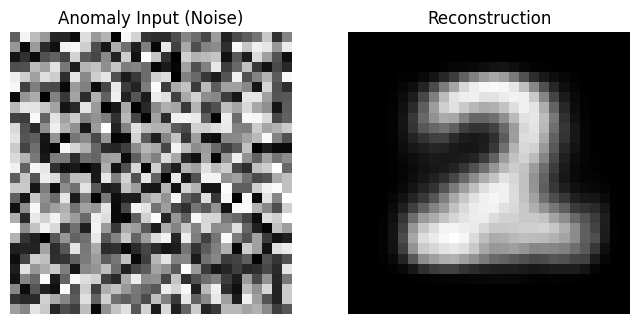

In [44]:
# -------------------------
# Visualize the Anomaly and Its Reconstruction
# -------------------------
plt.figure(figsize=(8, 4))

# Display the anomaly input image
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(anomaly), cmap='gray')
plt.title("Anomaly Input (Noise)")
plt.axis('off')

# Display the reconstruction of the anomaly
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(reconstructed_anomaly), cmap='gray')
plt.title("Reconstruction")
plt.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Reconstruction error for the handwritten digit: 0.053328734


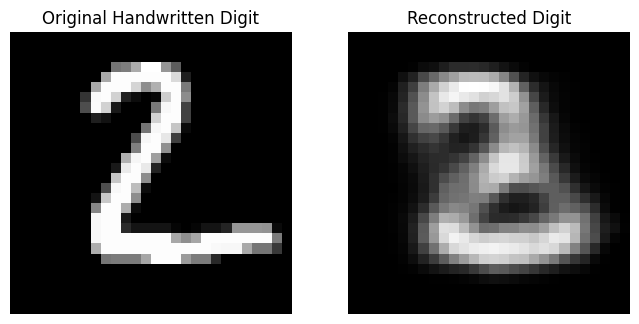

In [45]:
# Evaluate reconstruction on a handwritten digit from the test set
# Let's pick one sample handwritten digit from x_test (index 1 in this example)
handwritten_digit = x_test[1]
handwritten_digit_batch = np.expand_dims(handwritten_digit, axis=0)

# Reconstruct the handwritten digit using the VAE
reconstructed_handwritten = vae.predict(handwritten_digit_batch)

# Compute the reconstruction error (mean squared error)
error_handwritten = np.mean(np.square(handwritten_digit - reconstructed_handwritten[0]))
print("Reconstruction error for the handwritten digit:", error_handwritten)

# Visualize the original handwritten digit and its reconstruction
plt.figure(figsize=(8, 4))

# Original handwritten digit
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(handwritten_digit), cmap='gray')
plt.title("Original Handwritten Digit")
plt.axis('off')

# Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(reconstructed_handwritten), cmap='gray')
plt.title("Reconstructed Digit")
plt.axis('off')

plt.show()


- MNIST Digit (0.02627): The model reconstructs this digit extremely well since it was trained on similar data.

- Handwritten Digit (0.05333): Slightly higher error than the MNIST digit, but still low, indicating a good reconstruction of a typical digit.

- Random Noise (0.24854): Much higher error, showing the model struggles to reconstruct data it wasn't trained on.

In short, lower reconstruction errors indicate familiar, well-reconstructed data, while higher errors flag anomalies.